In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def validation_curve(model):
    rmse_train = model.evals_result_['learn']['RMSE']
    rmse_valid = model.evals_result_['validation']['RMSE']
    n = model.get_all_params().get('iterations')
    x=[i for i in range(0,n)]
    plt.plot(x,rmse_train, label='train');
    plt.plot(x,rmse_valid, label='valid');
    plt.title('Metric during training')
    plt.xlabel('iterations')
    plt.ylabel('rmse')    

In [3]:
%%time
# read train and test prepared in the notebook data_prep_4mod
train = pd.read_csv('data/train_numfeatures.csv.gz') 
test =  pd.read_csv('data/test_numfeatures.csv.gz')

CPU times: user 59.7 s, sys: 5.64 s, total: 1min 5s
Wall time: 1min 9s


Use sales with 'date_block_num' from 12 to 32 for modeling and sales with 'date_block_num'equal 33 for validation.
To train model for prediction on test, use sales with 'date_block_num' from 12 to 33

In [4]:
lag_var = ['tg', 'tg_sum', 'tg_mean', 'tg_shop', 'tg_item', 'tg_cat']

train = train[list(set(train) - set(lag_var))]
test = test[list(set(test) - set(lag_var))]

In [5]:
train = train.astype({'mean_price_l1':'int32'})
test = test.astype({'mean_price_l1':'int32'})

In [6]:
# train, trainv and valid
train = train[train['date_block_num']>11]
trainv = train[train['date_block_num']!=33]
valid = train[train['date_block_num']==33]

catboost with default hyperparameters on categorical features item_id, item_category_id, shop_id, month, mean_price_l1 and numerical features date_block_num, nrow_block

In [8]:
features = ['item_id', 'item_category_id', 'shop_id', 'month', 'mean_price_l1',\
            'date_block_num', 'nrow_block','target']
cat = ['item_id', 'item_category_id', 'shop_id', 'month','mean_price_l1']


In [9]:
%%time
X_train = trainv[features].drop('target', axis=1)
y_train = trainv['target']
X_valid = valid[features].drop('target', axis=1)
y_valid = valid['target']

train_pool = Pool(X_train, y_train, cat_features=cat)
eval_pool = Pool(X_valid, y_valid, cat_features=cat)

model = CatBoostRegressor(iterations=100)
model.fit(train_pool, eval_set=eval_pool)

Learning rate set to 0.5
0:	learn: 1.0549091	test: 1.0801223	best: 1.0801223 (0)	total: 1.26s	remaining: 2m 4s
1:	learn: 1.0060729	test: 1.0665570	best: 1.0665570 (1)	total: 2.23s	remaining: 1m 49s
2:	learn: 0.9857983	test: 1.0662772	best: 1.0662772 (2)	total: 2.85s	remaining: 1m 32s
3:	learn: 0.9753272	test: 1.0618573	best: 1.0618573 (3)	total: 3.62s	remaining: 1m 26s
4:	learn: 0.9666662	test: 1.0648216	best: 1.0618573 (3)	total: 4.07s	remaining: 1m 17s
5:	learn: 0.9613195	test: 1.0611371	best: 1.0611371 (5)	total: 4.65s	remaining: 1m 12s
6:	learn: 0.9567077	test: 1.0577039	best: 1.0577039 (6)	total: 5.45s	remaining: 1m 12s
7:	learn: 0.9527669	test: 1.0579914	best: 1.0577039 (6)	total: 6.08s	remaining: 1m 9s
8:	learn: 0.9509107	test: 1.0572091	best: 1.0572091 (8)	total: 6.61s	remaining: 1m 6s
9:	learn: 0.9464386	test: 1.0560600	best: 1.0560600 (9)	total: 7.08s	remaining: 1m 3s
10:	learn: 0.9442771	test: 1.0546088	best: 1.0546088 (10)	total: 7.65s	remaining: 1m 1s
11:	learn: 0.9426608	

94:	learn: 0.8979386	test: 1.0479194	best: 1.0338570 (63)	total: 49.4s	remaining: 2.6s
95:	learn: 0.8977936	test: 1.0476179	best: 1.0338570 (63)	total: 49.9s	remaining: 2.08s
96:	learn: 0.8973962	test: 1.0526845	best: 1.0338570 (63)	total: 50.4s	remaining: 1.56s
97:	learn: 0.8972123	test: 1.0526153	best: 1.0338570 (63)	total: 50.8s	remaining: 1.04s
98:	learn: 0.8969409	test: 1.0522032	best: 1.0338570 (63)	total: 51.4s	remaining: 519ms
99:	learn: 0.8965316	test: 1.0540632	best: 1.0338570 (63)	total: 51.9s	remaining: 0us

bestTest = 1.03385696
bestIteration = 63

Shrink model to first 64 iterations.
CPU times: user 5min 2s, sys: 24.1 s, total: 5min 26s
Wall time: 1min


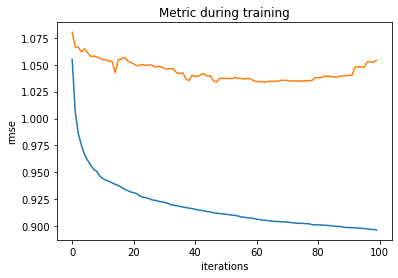

In [10]:
validation_curve(model)

In [11]:
feature_imp = pd.DataFrame({'features':X_train.columns, 'importance':model.feature_importances_}).sort_values('importance', ascending=False, ignore_index=True)
feature_imp

,features,importance
0,item_id,46.992258
1,shop_id,19.080470
2,item_category_id,11.277874
3,mean_price_l1,7.445082
4,date_block_num,6.968069
5,nrow_block,6.615542
6,month,1.620706


In [27]:
y_pred = model.predict(X_valid,
        prediction_type=None,
        ntree_start=0,
        ntree_end=64,
        thread_count=-1)#.clip(min=0, max=20)

In [28]:
print('rmse on valid:', np.sqrt(mean_squared_error(y_valid,y_pred)))

rmse on valid: 1.0338569597201919


catboost on all features

In [16]:
%%time
X_train = trainv.drop('target', axis=1)
y_train = trainv['target']
X_valid = valid.drop('target', axis=1)
y_valid = valid['target']

train_pool = Pool(X_train, y_train, cat_features=cat)
eval_pool = Pool(X_valid, y_valid, cat_features=cat)

model = CatBoostRegressor(iterations=50, learning_rate=0.08, random_seed=2022)
model.fit(train_pool, eval_set=eval_pool)

0:	learn: 1.1546515	test: 1.1134198	best: 1.1134198 (0)	total: 1.4s	remaining: 1m 8s
1:	learn: 1.1250587	test: 1.0939117	best: 1.0939117 (1)	total: 2.61s	remaining: 1m 2s
2:	learn: 1.0991907	test: 1.0764371	best: 1.0764371 (2)	total: 3.88s	remaining: 1m
3:	learn: 1.0763670	test: 1.0612062	best: 1.0612062 (3)	total: 4.75s	remaining: 54.6s
4:	learn: 1.0561252	test: 1.0478811	best: 1.0478811 (4)	total: 5.39s	remaining: 48.5s
5:	learn: 1.0389367	test: 1.0369886	best: 1.0369886 (5)	total: 6.11s	remaining: 44.8s
6:	learn: 1.0231914	test: 1.0267298	best: 1.0267298 (6)	total: 6.88s	remaining: 42.2s
7:	learn: 1.0098340	test: 1.0175270	best: 1.0175270 (7)	total: 7.86s	remaining: 41.3s
8:	learn: 0.9978198	test: 1.0096411	best: 1.0096411 (8)	total: 8.8s	remaining: 40.1s
9:	learn: 0.9873599	test: 1.0030888	best: 1.0030888 (9)	total: 9.6s	remaining: 38.4s
10:	learn: 0.9775044	test: 0.9953694	best: 0.9953694 (10)	total: 10.5s	remaining: 37.1s
11:	learn: 0.9693622	test: 0.9901305	best: 0.9901305 (11)	

In [17]:
model.best_iteration_

22

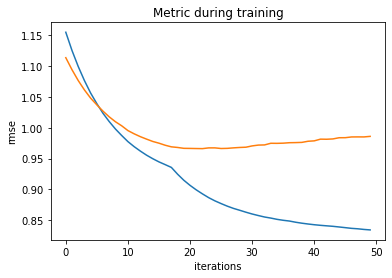

In [18]:
validation_curve(model)

the best learning_rate within 100 iterations is 0.08, best number of iterations is 22, RMSE on valid 0.966

In [19]:
feature_imp = pd.DataFrame({'features':X_train.columns, 'importance':model.feature_importances_}).sort_values('importance', ascending=False, ignore_index=True)
feature_imp

,features,importance
0,tg_lag1,39.142756
1,item_id,13.016325
2,shop_id,10.575321
3,tg_item_lag1,9.071915
4,tg_lag3,6.606821
5,mean_price_l1,5.373145
6,item_category_id,4.047850
7,tg_lag2,3.641682
8,tg_cat_lag3,1.234357
9,date_block_num,1.202007


let's build a model with learning_rate=0.08 on features with importance > 0

In [20]:
important_features = np.append(feature_imp[feature_imp['importance']>0]['features'].values,'target')


In [21]:
important_features

array(['tg_lag1', 'item_id', 'shop_id', 'tg_item_lag1', 'tg_lag3',
       'mean_price_l1', 'item_category_id', 'tg_lag2', 'tg_cat_lag3',
       'date_block_num', 'tg_d2-1', 'tg_mean_lag2', 'tg_shop_lag3',
       'tg_cat_lag2', 'tg_lag12', 'tg_shop_lag2', 'tg_item_d2-1',
       'tg_item_lag2', 'tg_mean_d3-2', 'tg_sum_lag2', 'tg_mean_lag3',
       'month', 'target'], dtype=object)

In [22]:
%%time
X_train = trainv[important_features].drop('target', axis=1)
y_train = trainv['target']
X_valid = valid[important_features].drop('target', axis=1)
y_valid = valid['target']

train_pool = Pool(X_train, y_train, cat_features=cat)
eval_pool = Pool(X_valid, y_valid, cat_features=cat)

model = CatBoostRegressor(iterations=50, learning_rate=0.08)
model.fit(train_pool, eval_set=eval_pool)

0:	learn: 1.1545799	test: 1.1132413	best: 1.1132413 (0)	total: 1.05s	remaining: 51.4s
1:	learn: 1.1249621	test: 1.0935775	best: 1.0935775 (1)	total: 1.92s	remaining: 46.1s
2:	learn: 1.0991931	test: 1.0762327	best: 1.0762327 (2)	total: 2.75s	remaining: 43.1s
3:	learn: 1.0762086	test: 1.0616231	best: 1.0616231 (3)	total: 3.38s	remaining: 38.9s
4:	learn: 1.0564519	test: 1.0485077	best: 1.0485077 (4)	total: 3.93s	remaining: 35.3s
5:	learn: 1.0386707	test: 1.0369732	best: 1.0369732 (5)	total: 4.46s	remaining: 32.7s
6:	learn: 1.0231604	test: 1.0262190	best: 1.0262190 (6)	total: 5.32s	remaining: 32.7s
7:	learn: 1.0097377	test: 1.0169185	best: 1.0169185 (7)	total: 5.97s	remaining: 31.3s
8:	learn: 0.9976418	test: 1.0082625	best: 1.0082625 (8)	total: 6.64s	remaining: 30.3s
9:	learn: 0.9871771	test: 1.0012525	best: 1.0012525 (9)	total: 7.28s	remaining: 29.1s
10:	learn: 0.9775564	test: 0.9949360	best: 0.9949360 (10)	total: 7.91s	remaining: 28s
11:	learn: 0.9694309	test: 0.9902005	best: 0.9902005 (

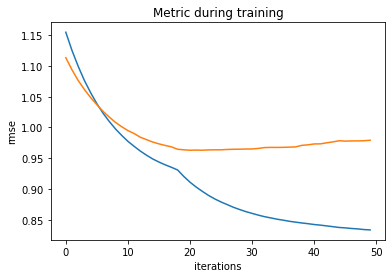

In [23]:
validation_curve(model)

the best number of iterations for a model on important_features is 21 (numeration from 0), RMSE on valid 0.963. 
we build a model to use in ensemble, so to make model prediction different from predictions of other models, let's use not all features, but most important

let's build a model on train (21 iterations, learning rate 0.08, important_features) and predict on test

In [24]:
%%time
X_train = train[important_features].drop('target', axis=1)
y_train = train['target']

train_pool = Pool(X_train, y_train, cat_features=cat)

catboost_imp_features = CatBoostRegressor(iterations=21, learning_rate=0.08)
catboost_imp_features.fit(train_pool)

0:	learn: 1.1531362	total: 1.09s	remaining: 21.8s
1:	learn: 1.1239819	total: 1.77s	remaining: 16.8s
2:	learn: 1.0986969	total: 2.77s	remaining: 16.6s
3:	learn: 1.0758739	total: 3.65s	remaining: 15.5s
4:	learn: 1.0562718	total: 4.36s	remaining: 14s
5:	learn: 1.0389327	total: 5.03s	remaining: 12.6s
6:	learn: 1.0236647	total: 5.58s	remaining: 11.2s
7:	learn: 1.0100974	total: 6.22s	remaining: 10.1s
8:	learn: 0.9984540	total: 6.92s	remaining: 9.23s
9:	learn: 0.9880638	total: 7.45s	remaining: 8.19s
10:	learn: 0.9790945	total: 7.97s	remaining: 7.24s
11:	learn: 0.9706992	total: 8.81s	remaining: 6.61s
12:	learn: 0.9632673	total: 9.38s	remaining: 5.77s
13:	learn: 0.9569214	total: 10.1s	remaining: 5.06s
14:	learn: 0.9509210	total: 10.7s	remaining: 4.27s
15:	learn: 0.9459859	total: 11.4s	remaining: 3.57s
16:	learn: 0.9414812	total: 12.2s	remaining: 2.86s
17:	learn: 0.9371119	total: 12.9s	remaining: 2.16s
18:	learn: 0.9336164	total: 13.6s	remaining: 1.43s
19:	learn: 0.9230469	total: 14.6s	remaining

In [ ]:
test_init =  pd.read_csv('data/test.csv.gz')

In [26]:
y_pred = catboost_imp_features.predict(test[important_features[:-1]]).clip(min=0, max=20)
pd.DataFrame({'ID': test_init['ID'], 'item_cnt_month': y_pred}).to_csv("submissions/catboost.csv", index=False)


RMSE on test on private/public leaderboard is 1.009/1.009

In [27]:
catboost_imp_features.save_model('models/catboost_imp_features')

In [29]:
# bst = CatBoostRegressor()
# bst.load_model('models/catboost_imp_features')

In [31]:
predontrain_catb = catboost_imp_features.predict(train[important_features[:-1]]).clip(min=0, max=20)
pd.DataFrame({'catb': predontrain_catb}).to_csv("data/predontrain_catb.csv", index=False)

In [32]:
print('rmse on train:', np.sqrt(mean_squared_error(y_train,predontrain_catb)))

rmse on train: 0.9126242564699992
